In [94]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt, mpld3

import csv

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import spacy

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        try:
          doc = nlp(" ".join(sent)) 
          texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        except:
          pass
    return texts_out


In [51]:
def get_cleaned_tweet(tweets):
    all_texts = []
    
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in tweets]
    
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    data_words = list(sent_to_words(data))
    
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
    
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod)
    
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Corpus
    return data_lemmatized

In [119]:
def save_plot_to_html(x, y, labels, cluster_results, filename='user-cluster.html'):
    
    colors = ['#32a852', '#323aa8', '#a83244', '#a8a232']
    
    color_array = []
    for cluster in cluster_results:
        color_array.append(colors[cluster])
    
    fig, ax = plt.subplots(figsize=(15,7.5))

    scatter = ax.scatter(x, y, s=80, c=color_array)

    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)

    mpld3.plugins.connect(fig, tooltip)
        
    mpld3.save_html(fig, filename)
        

In [7]:
twitter_data = pd.read_csv('/Users/joeepstein/code/targifor/twitter-clustering/twitter-health-generic.csv')

In [53]:
# According to https://stackoverflow.com/questions/54573853/nltk-available-languages-for-stopwords
# As of 2020 these languages are supported:

# 'arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek',
# 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian',
# 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish'

stop_words = stopwords.words('portuguese')


# Official documentation: https://spacy.io/models
# Supporting the following langauges:

# 'Chinese', 'Danish', 'Dutch', 'English', 'French', 'German', 'Greek', 'Italian', 'Japanese',
# 'Lithuanian', 'Norwegian Bokmål', 'Polish', 'Portuguese', 'Romanian', 'Russian', 'Spanish'

nlp = spacy.load('pt_core_news_lg')

In [8]:
print(twitter_data.shape)
print(len(twitter_data.username.unique()))

(50018, 39)
31227


In [18]:
user_tweet_count = {}

for index, tweet in twitter_data.iterrows():
    if tweet['username'] not in user_tweet_count:
        user_tweet_count[tweet.username] = 1
    else:
        user_tweet_count[tweet.username] += 1

In [103]:
multiple_comment_users = [user for user in user_tweet_count if user_tweet_count[user] > 10]

In [104]:
len(multiple_comment_users)

257

In [105]:
filtered_twitter_data = twitter_data[twitter_data['username'].isin(multiple_comment_users)]

In [106]:
len(filtered_twitter_data)

8627

In [107]:
user_all_tweets = {}

for index, tweet in filtered_twitter_data.iterrows():
    if tweet['username'] not in user_all_tweets:
        user_all_tweets[tweet.username] = [tweet.tweet]
    else:
        user_all_tweets[tweet.username].append(tweet.tweet)

In [108]:
user_cleaned_tweets = {}

for user in user_all_tweets:
    user_cleaned_tweets[user] = get_cleaned_tweet(user_all_tweets[user])

In [109]:
user_keyword_count_dict = {}

for user in user_cleaned_tweets:
    user_keyword_count_dict[user] = {}
    
    for tweet in user_cleaned_tweets[user]:
        for keyword in tweet:
            if keyword not in user_keyword_count_dict[user]:
                user_keyword_count_dict[user][keyword] = 1
            else:
                user_keyword_count_dict[user][keyword] += 1

In [110]:
vocab_list = []

for user in user_keyword_count_dict:
    for keyword in user_keyword_count_dict[user]:
        if keyword not in vocab_list:
            vocab_list.append(keyword)

In [111]:
print(len(vocab_list))

15149


In [112]:
user_all_keyword_dict = {}

for user in user_keyword_count_dict:
    user_all_keyword_dict[user] = []
    
    for word in vocab_list:
        if word in user_keyword_count_dict[user]:
            user_all_keyword_dict[user].append(user_keyword_count_dict[user][word])
        else:
            user_all_keyword_dict[user].append(0)

In [113]:
all_keyword_vectors = []
all_users = []

for user in user_all_keyword_dict:
    all_keyword_vectors.append(user_all_keyword_dict[user])
    all_users.append(user)

In [114]:
# PCA
pca_model = PCA(random_state=23, n_components=30)
init_values = pca_model.fit_transform(all_keyword_vectors)

tsne_model = TSNE(random_state=23, n_components=2)
plot_values = tsne_model.fit_transform(init_values)

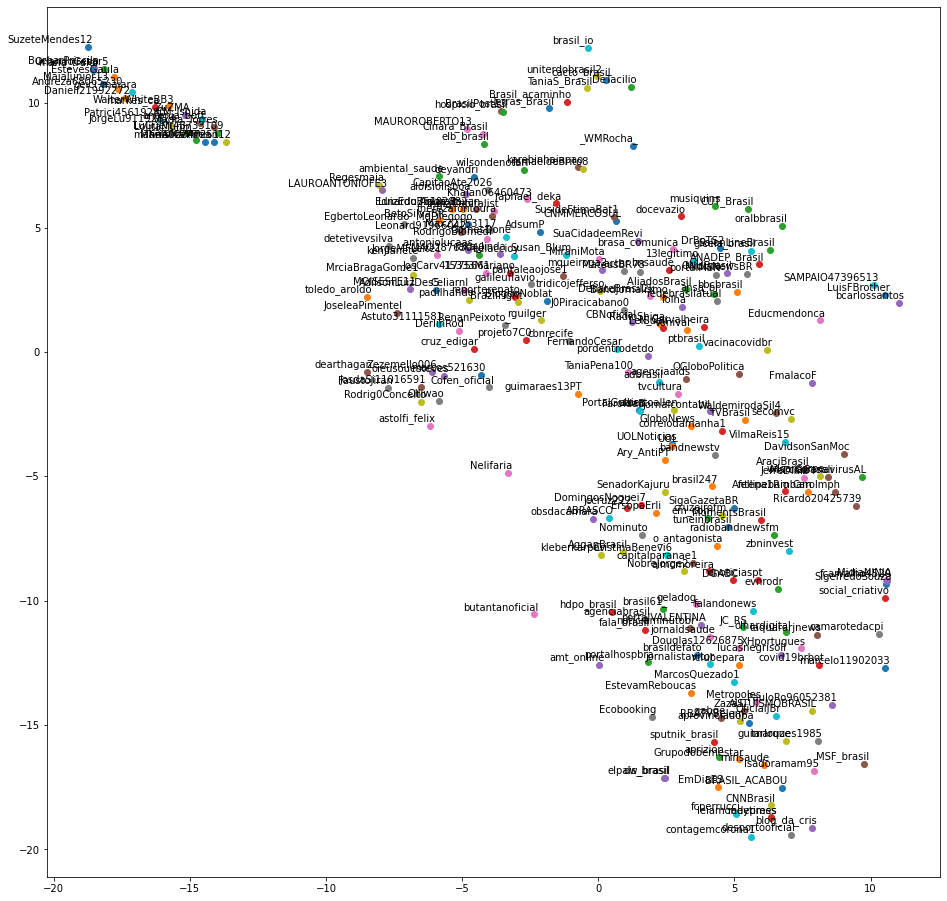

In [115]:
# Plot
x = []
y = []

for value in plot_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))

for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(all_users[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
    
plt.show()

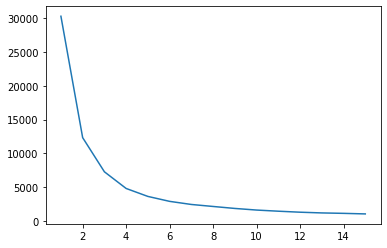

In [116]:
# K-Means
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k, algorithm='full')
    km = km.fit(plot_values)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances)
plt.show()

In [117]:
km = KMeans(n_clusters=4, algorithm='full')
km = km.fit(plot_values)

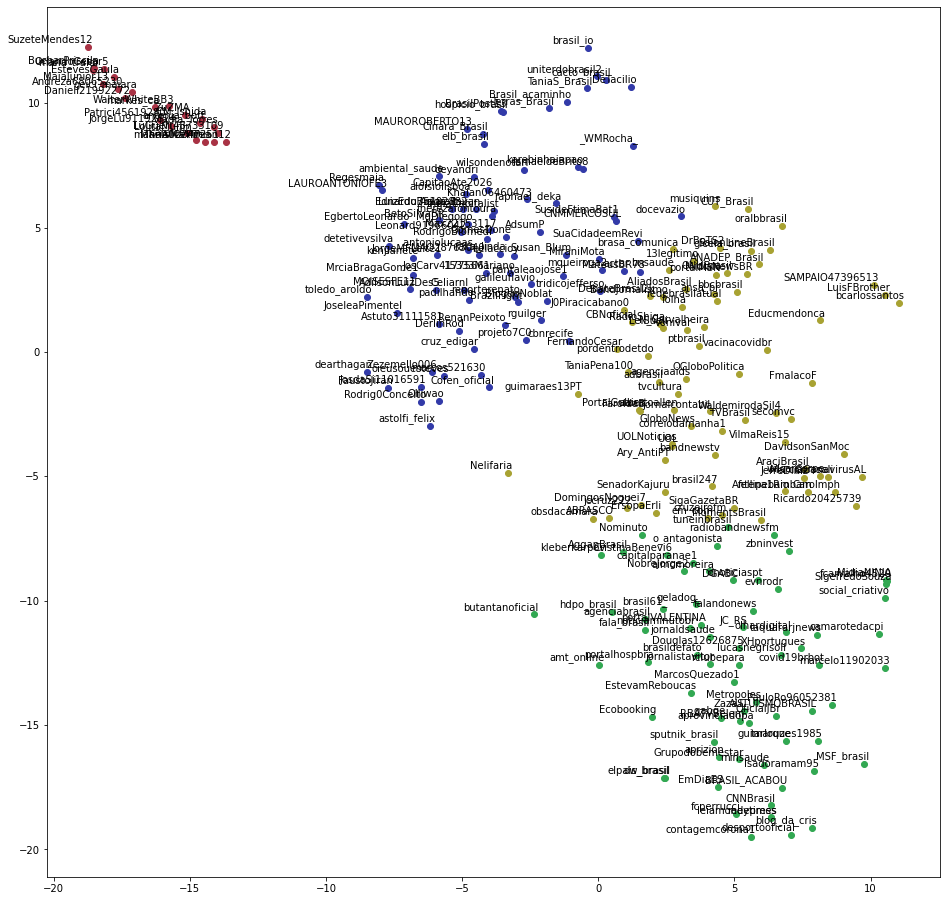

In [134]:
# Plot with cluster colors
# Plot
x = []
y = []

for value in plot_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))

colors = ['#32a852', '#323aa8', '#a83244', '#a8a232']

for i in range(len(x)):
    plt.scatter(x[i],y[i],c=colors[km.labels_[i]])
    plt.annotate(all_users[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
    
plt.show()

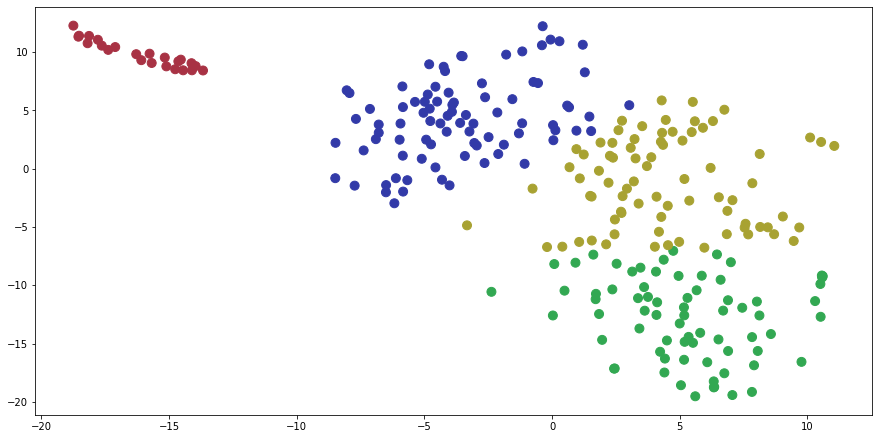

In [135]:
save_plot_to_html(x, y, all_users, km.labels_)

In [136]:
print(km.cluster_centers_)

[[  5.257655  -12.7606325]
 [ -3.5661514   4.291061 ]
 [-16.106876    9.829875 ]
 [  4.4309464  -1.2245054]]


In [139]:
counter = 1

for center in km.cluster_centers_:
    user_distances = {}
    
    for index, user in enumerate(all_users):
        point = np.array((x[index], y[index]))
        dist = np.linalg.norm(point - center)
        
        user_distances[user] = dist
    
    print("Cluster", counter)
    print()
    
    for loop in range(3):
        closest_user = min(user_distances, key=user_distances.get)
        print(closest_user)
        
        tweet_counter = 0
        
        for tweet in user_all_tweets[closest_user]:
            print(tweet)
            print()
            
            tweet_counter +=1
            
            if tweet_counter == 2:
                break
        
        del user_distances[closest_user]
        
    counter+=1

Cluster 1

rclubepara
O Brasil recebeu hoje (24) pela manhã em Guarulhos (SP), mais um lote de vacinas da Janssen contra Covid-19. O Ministério da Saúde anunciou a chegada de 300 mil doses do imunizante como parte do contrato de compra de 38 milhões de doses firmado com a farmacêutica.#Janssen #vacina  https://t.co/bG85TD2xYE

O ministro da Saúde, Marcelo Queiroga, disse que 1,5 milhão de doses da vacina da Janssen contra covid-19 chegam ao Brasil nesta terça (22), uma semana depois do previsto. A quantidade anunciada por ele é metade da anunciada em junho, quando foram previstas 3 milhões de doses.  https://t.co/RtXyI466xn

MarcosQuezado1
Brasil chega à marca de 90 milhões de doses aplicadas. Ministério da Saúde afirma que, até setembro, vai vacinar todo o público-alvo com a primeira dose.  https://t.co/4yX0rg33zK

Brasil chega hoje à importante marca de 90 milhões de vacinas contra covid aplicadas. Segundo o Ministério da Saúde, o número de doses disponibilizadas passou de 123 milhõe